## Linear Regression Example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import os
import sys
try:
    # Append PySpark to PYTHONPATH / Spark 2.1.0
    sys.path.append(os.path.join(os.environ["SPARK_HOME"], "python"))
    sys.path.append(os.path.join(os.environ["SPARK_HOME"], "python", "lib",
                                 "py4j-0.10.4-src.zip"))
except KeyError as e:
    print("SPARK_HOME is not set", e)
    sys.exit(1)
    
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.linalg import Vectors

In [2]:
spark_session = SparkSession.builder.getOrCreate()

### Generate Data

In [3]:
# y = b_o + b_1*x + error
# b_0 = 0.5, b_1 = 0.3, error = normally distributed
x = np.arange(100)
error = np.random.normal(0, size=(100,))
y = 0.5 + 0.3 * x + error

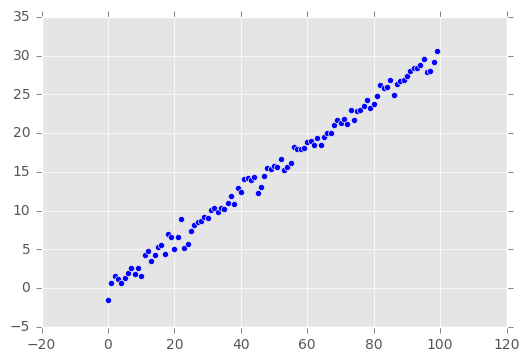

In [126]:
plt.scatter(x, y)
pass

### Convert to Spark DataFrame

In [5]:
data = pd.DataFrame([(i, j) for i, j in zip(x,y)], columns = ["x", "y"])

In [6]:
data_spark = spark_session.createDataFrame(data)

In [7]:
data_spark.show()

+---+-------------------+
|  x|                  y|
+---+-------------------+
|  0|-1.4822847921918212|
|  1| 0.6822733704442338|
|  2|  1.556229656305006|
|  3|  1.221400287595696|
|  4| 0.6544211332334076|
|  5|  1.254190577522842|
|  6| 1.8921271515977705|
|  7| 2.5472372574617226|
|  8| 1.8034424889804512|
|  9| 2.5530329871415294|
| 10| 1.6157991330444934|
| 11|   4.22349656505238|
| 12|  4.806936607967312|
| 13|  3.485724880733545|
| 14|  4.219038329130181|
| 15|  5.294550878047955|
| 16|  5.613306199839113|
| 17|  4.425257013046646|
| 18|  7.032431255876554|
| 19|  6.574359668611116|
+---+-------------------+
only showing top 20 rows



In [8]:
df = spark_session.createDataFrame((data_spark
 .rdd
 .map(lambda row: (row[1], 0.5, Vectors.dense(row[0]))) 
), ["label", "weight", "features"] )

### Simple Linear Regression

In [9]:
lr = LinearRegression(maxIter=5, regParam=0.0, solver="normal", weightCol="weight")

In [10]:
model = lr.fit(df)

In [11]:
model.coefficients

DenseVector([0.3029])

In [12]:
model.intercept

0.14448316500870423

In [119]:
b_0_hat = model.intercept
b_1_hat = model.coefficients.values[0]
y_hat = b_0_hat + b_1_hat * x

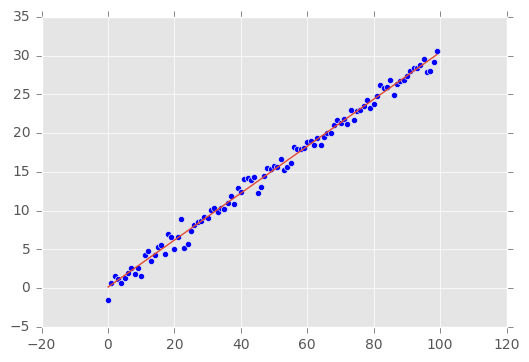

In [129]:
plt.scatter(x, y)
plt.plot(x, y_hat)
pass

In [130]:
model.transform(df).show()

+-------------------+------+--------+-------------------+
|              label|weight|features|         prediction|
+-------------------+------+--------+-------------------+
|-1.4822847921918212|   0.5|   [0.0]|0.14448316500870423|
| 0.6822733704442338|   0.5|   [1.0]| 0.4473971922469396|
|  1.556229656305006|   0.5|   [2.0]| 0.7503112194851749|
|  1.221400287595696|   0.5|   [3.0]| 1.0532252467234102|
| 0.6544211332334076|   0.5|   [4.0]| 1.3561392739616456|
|  1.254190577522842|   0.5|   [5.0]|  1.659053301199881|
| 1.8921271515977705|   0.5|   [6.0]| 1.9619673284381163|
| 2.5472372574617226|   0.5|   [7.0]|  2.264881355676352|
| 1.8034424889804512|   0.5|   [8.0]|  2.567795382914587|
| 2.5530329871415294|   0.5|   [9.0]|  2.870709410152822|
| 1.6157991330444934|   0.5|  [10.0]| 3.1736234373910577|
|   4.22349656505238|   0.5|  [11.0]| 3.4765374646292933|
|  4.806936607967312|   0.5|  [12.0]| 3.7794514918675284|
|  3.485724880733545|   0.5|  [13.0]|  4.082365519105764|
|  4.219038329

In [114]:
# save model
model.write().overwrite().save("model")

### Predict New Data

In [15]:
model_load = LinearRegressionModel.load("model")

In [16]:
# need the index as dummy column
predict_df = spark_session.createDataFrame([(1, Vectors.dense(0))], ["index", "features"])

In [17]:
model_load.transform(predict_df).show()

+-----+--------+-------------------+
|index|features|         prediction|
+-----+--------+-------------------+
|    1|   [0.0]|0.14448316500870423|
+-----+--------+-------------------+

